# 2021/12/06
The original notebook is from https://github.com/ArtRand/CytosineMethylationAnalysis/blob/master/notebooks/Zymo_Analysis.ipynb

In [3]:
import os
import numpy as np
import pandas as pd

In [4]:
input_path='/fastscratch/c-panz/2021-12-07/CytosineMethylationAnalysis/data/zymo/multiset/'

# load the data
names=['site', 'strand', 'pC', 'pmC', 'phmC', 'read']
c_mulset = pd.read_table(os.path.join(input_path,"C-barcoded_calls.tsv"), names = names)
mc_mulset = pd.read_table(os.path.join(input_path,"mC-barcoded_calls.tsv"), names = names)
hmc_mulset = pd.read_table(os.path.join(input_path,"hmC-barcoded_calls.tsv"), names = names)

In [25]:
c_mulset.shape, mc_mulset.shape, hmc_mulset.shape

((218642, 6), (115635, 6), (212680, 6))

In [26]:
hmc_mulset

,site,strand,pC,pmC,phmC,read
0,22,t,0.000000,0.000000,1.000000,makeson_PC_MA_286_R7.3_Zymo_Barcode_01_13_16_0...
1,24,t,0.000000,0.000000,1.000000,makeson_PC_MA_286_R7.3_Zymo_Barcode_01_13_16_0...
2,28,t,0.000000,0.000000,1.000000,makeson_PC_MA_286_R7.3_Zymo_Barcode_01_13_16_0...
3,33,t,0.255617,0.134413,0.609971,makeson_PC_MA_286_R7.3_Zymo_Barcode_01_13_16_0...
4,38,t,0.288845,0.000000,0.711155,makeson_PC_MA_286_R7.3_Zymo_Barcode_01_13_16_0...
...,...,...,...,...,...,...
212675,852,c,0.000000,0.000000,1.000000,makeson_PC_MA_286_R7.3_Zymo_Barcode_01_13_16_0...
212676,854,c,0.004936,0.000000,0.995064,makeson_PC_MA_286_R7.3_Zymo_Barcode_01_13_16_0...
212677,856,c,0.291284,0.000000,0.708716,makeson_PC_MA_286_R7.3_Zymo_Barcode_01_13_16_0...
212678,857,c,0.280432,0.000000,0.719568,makeson_PC_MA_286_R7.3_Zymo_Barcode_01_13_16_0...


In [106]:
test = hmc_mulset.pivot_table(index=['site'], aggfunc='size')
test.tail(10)

site
856    483
857    482
860    481
861    480
862    480
863    479
869    479
879    450
886    429
890    397
dtype: int64

In [32]:
hmc_mulset_t = hmc_mulset.loc[hmc_mulset['strand'] == 't']
hmc_mulset_t.shape

(103242, 6)

In [36]:
from __future__ import division
import sys
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 20


# Get the predicted label (use the maximum method)
def get_calls(data, strand):
    #.ix is deprecated
#    select_by_strand = data.ix[data['strand'] == strand]   
    select_by_strand = data.loc[data['strand'] == strand]
    calls = []
    for row in select_by_strand.itertuples():
        call = np.argmax(row[3:6]) #Returns the indices of the maximum values along an axis
        # row[3:6]: pC, pmC, phmC, index is 0,1,2, if the np.argmax(row[3:6]) == value in phmC column, it will return 2
        calls.append(call)
    return calls

In [ ]:
c_calls = get_calls(g0, strand) ### Predicted labels
c_labels = [0] * len(c_calls) ### True labels
mc_calls = get_calls(g1, strand)
mc_labels = [1] * len(mc_calls)
hmc_calls = get_calls(g2, strand)
hmc_labels = [2] * len(hmc_calls)
calls = c_calls + mc_calls + hmc_calls 
labels = c_labels + mc_labels + hmc_labels
cm = confusion_matrix(labels, calls)

In [66]:
# Show confusion matrix
def make_confusion_matrix(g0, g1, g2, strand):
    c_calls = get_calls(g0, strand) ### Predicted labels
    c_labels = [0] * len(c_calls) ### True labels
    mc_calls = get_calls(g1, strand)
    mc_labels = [1] * len(mc_calls)
    hmc_calls = get_calls(g2, strand)
    hmc_labels = [2] * len(hmc_calls)
    calls = c_calls + mc_calls + hmc_calls 
    labels = c_labels + mc_labels + hmc_labels
    cm = confusion_matrix(labels, calls)
    print(cm) #print confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis] #add row value(true label)
    print(cm_normalized)
    return cm_normalized

In [67]:
cm_t = make_confusion_matrix(c_mulset, mc_mulset, hmc_mulset, 't')

[[79927 13161 15398]
 [ 9796 41848  5824]
 [16886  8109 78247]]
[[0.74972094 0.12345112 0.14443433]
 [0.15520137 0.66301214 0.09227162]
 [0.16976143 0.08152289 0.7866471 ]]


In [68]:
cm_c = make_confusion_matrix(c_mulset, mc_mulset, hmc_mulset, 'c')

[[71247 15729 23180]
 [11213 38452  8502]
 [20445 11103 77890]]
[[0.69235703 0.15284972 0.2252563 ]
 [0.17175725 0.58899577 0.13023099]
 [0.18658964 0.10133063 0.71085679]]


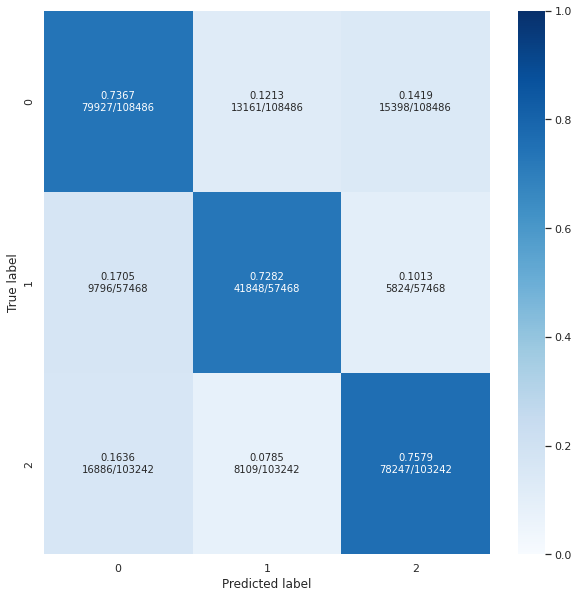

In [89]:
def plot_cm(g0, g1, g2, strand, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with annotations.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    c_calls = get_calls(g0, strand) ### Predicted labels
    c_labels = [0] * len(c_calls) ### True labels
    mc_calls = get_calls(g1, strand)
    mc_labels = [1] * len(mc_calls)
    hmc_calls = get_calls(g2, strand)
    hmc_labels = [2] * len(hmc_calls)
    y_pred = c_calls + mc_calls + hmc_calls 
    y_true = c_labels + mc_labels + hmc_labels
    cm = confusion_matrix(y_true, y_pred)
    # Normalise: Calcuate precision
#    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #add column value in 1st row(true label)
    cm_sum = cm.sum(axis=1)[:, np.newaxis]
    cm_perc = cm / cm_sum.astype(float)
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            s = cm_sum[i]
            annot[i, j] = '%.4f\n%d/%d' % (p, c, s)
    
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmn = pd.DataFrame(cmn)
    cmn.index.name = 'True label'
    cmn.columns.name = 'Predicted label'
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cmn, annot=annot, fmt='', ax=ax, cmap="Blues", vmin=0, vmax=1) ##Set up bar range
#    plt.savefig(filename)
    plt.show()
    
plot_cm(c_mulset, mc_mulset, hmc_mulset, 't')

## Figure 2C

In [95]:
from sklearn.metrics import confusion_matrix, classification_report

g0, g1, g2 = c_mulset, mc_mulset, hmc_mulset
strand = 't'

c_calls = get_calls(g0, strand) ### Predicted labels
c_labels = [0] * len(c_calls) ### True labels
mc_calls = get_calls(g1, strand)
mc_labels = [1] * len(mc_calls)
hmc_calls = get_calls(g2, strand)
hmc_labels = [2] * len(hmc_calls)
calls = c_calls + mc_calls + hmc_calls 
labels = c_labels + mc_labels + hmc_labels

In [96]:
print(classification_report(labels, calls, digits=3))

              precision    recall  f1-score   support

           0      0.750     0.737     0.743    108486
           1      0.663     0.728     0.694     57468
           2      0.787     0.758     0.772    103242

    accuracy                          0.743    269196
   macro avg      0.733     0.741     0.736    269196
weighted avg      0.745     0.743     0.744    269196



In [97]:
print(classification_report(calls, labels, digits=3))

              precision    recall  f1-score   support

           0      0.737     0.750     0.743    106609
           1      0.728     0.663     0.694     63118
           2      0.758     0.787     0.772     99469

    accuracy                          0.743    269196
   macro avg      0.741     0.733     0.736    269196
weighted avg      0.743     0.743     0.742    269196



In [91]:
_confusion_matrix = confusion_matrix(labels, calls)
acc = np.sum(_confusion_matrix.diagonal()) / np.sum(_confusion_matrix)
acc

0.7430348147817947

[[79927  9796 16886]
 [13161 41848  8109]
 [15398  5824 78247]]
[[0.74972094 0.09188718 0.15839188]
 [0.20851421 0.66301214 0.12847365]
 [0.154802   0.05855091 0.7866471 ]]


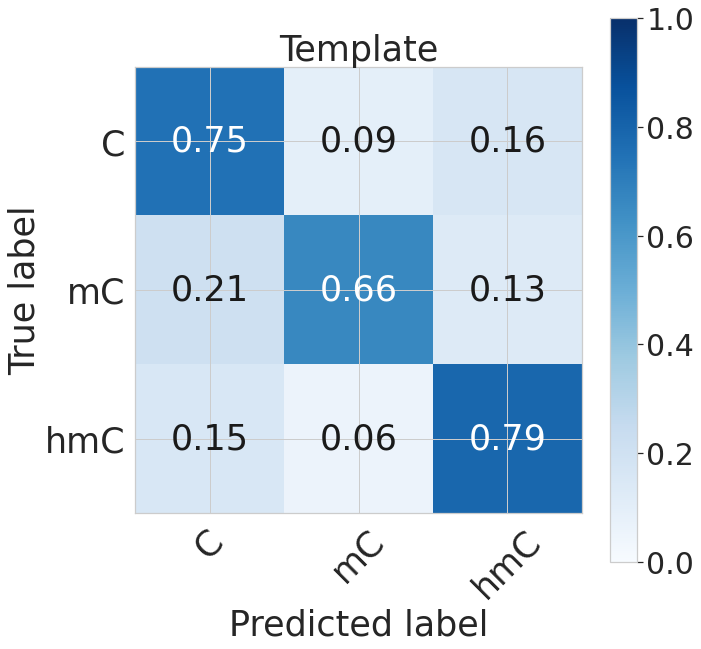

In [78]:
# Show confusion matrix
def make_confusion_matrix(g0, g1, g2, strand):
    c_calls = get_calls(g0, strand) ### Predicted labels
    c_labels = [0] * len(c_calls) ### True labels
    mc_calls = get_calls(g1, strand)
    mc_labels = [1] * len(mc_calls)
    hmc_calls = get_calls(g2, strand)
    hmc_labels = [2] * len(hmc_calls)
    calls = c_calls + mc_calls + hmc_calls 
    labels = c_labels + mc_labels + hmc_labels
    cm = confusion_matrix(calls, labels)
    print(cm) #print confusion matrix
    ## Calcuate precision
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #add column value in 1st row(true label)
    print(cm_normalized)
    return cm_normalized

def plot_confusion_matrix(g0, g1, g2, strand, title='Confusion matrix', out_file=None):
    cm = make_confusion_matrix(g0, g1, g2, strand)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=35)
    width, height = cm.shape #the wideth, height is equal to the label number
    for x in range(width):
        for y in range(height):
            plt.annotate(str(round(cm[x][y], 2)), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center', fontsize=35, color=('w' if x == y else 'k'))
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, ["C", "mC", "hmC"], rotation=45, fontsize=35)
    plt.yticks(tick_marks, ["C", "mC", "hmC"], fontsize=35)
    plt.ylabel('True label', fontsize=35)
    plt.xlabel('Predicted label', fontsize=35)
    plt.clim(0, 1)  ### Set up color bar
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=30) 
    
    if out_file is not None:
        plt.savefig(out_file)
        
plot_confusion_matrix(c_mulset, mc_mulset, hmc_mulset, 't', "Template", None)

In [ ]:
cm = confusion_matrix(y_true, y_pred)

Determining most accurate context

#### Figure 2C 